# Entropy vs Accuracy

Here we study how starting with a maximum entropy dataset, and therefore, maximising the entropy transfer to the model, results in better trained models

In [1]:
import znrnd

import numpy as np
import optax
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from neural_tangents import stax

import matplotlib.pyplot as plt
import copy

### Trivial test

In [2]:
data_generator = znrnd.data.MNISTGenerator(ds_size=1000)

2022-05-11 18:26:42.495954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/targets/x86_64-linux/lib:/usr/local/cuda-11.2/targets/x86_64-linux/lib:
2022-05-11 18:26:42.495974: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
model = stax.serial(
    stax.Conv(32, (3, 3)),
    stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2)),
    stax.Conv(64, (3, 3)),
    stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2)),
    stax.Flatten(),
    stax.Dense(256),
    stax.Relu(),
    stax.Dense(10)
)

In [4]:
production_model = znrnd.models.NTModel(
        nt_module=model,
        optimizer=optax.adam(learning_rate=0.001),
        loss_fn=znrnd.loss_functions.CrossEntropyLoss(classes=10, apply_softmax=False),
        input_shape=(1, 28, 28, 1),
        training_threshold=0.001
    )

In [5]:
test_ds = {
    "inputs": data_generator.ds_test["image"],
    "targets": data_generator.ds_test["label"]
}

In [ ]:
maximum_agent = znrnd.agents.ApproximateMaximumEntropy(
    target_network=production_model, 
    data_generator=data_generator,
    samples=30
)

In [6]:

random_agent = znrnd.agents.RandomAgent(
    data_generator=data_generator
)

In [193]:
max_ds = maximum_agent.build_dataset(target_size=30)

In [194]:
ntk = production_model.compute_ntk(x_i=max_ds, normalize=False)

In [195]:
max_entropy = znrnd.analysis.EntropyAnalysis(matrix=ntk["empirical"]).compute_von_neumann_entropy()

In [196]:
max_entropy

DeviceArray(0.5237574-0.j, dtype=complex64)

In [197]:
random_ds = random_agent.build_dataset(target_size=30)

In [198]:
ntk = production_model.compute_ntk(x_i=random_ds, normalize=False)

In [199]:
random_entropy = znrnd.analysis.EntropyAnalysis(matrix=ntk["empirical"]).compute_von_neumann_entropy()

In [200]:
random_entropy

DeviceArray(0.49159148-0.j, dtype=complex64)

In [201]:
max_ds = {
    "inputs": np.take(data_generator.ds_train["image"], maximum_agent.target_indices, axis=0),
    "targets": np.take(data_generator.ds_train["label"], maximum_agent.target_indices, axis=0)
}
random_ds = {
    "inputs": np.take(data_generator.ds_train["image"], random_agent.target_indices, axis=0),
    "targets": np.take(data_generator.ds_train["label"], random_agent.target_indices, axis=0)
}

In [202]:
max_final_entropy = []
random_final_entropy = []
max_losses = []
random_losses = []
max_accuracy = []
random_accuracy = []

for _ in range(5):
    max_model = znrnd.models.NTModel(
        nt_module=model,
        optimizer=optax.adam(learning_rate=0.001),
        loss_fn=znrnd.loss_functions.CrossEntropyLoss(classes=10, apply_softmax=False),
        input_shape=(1, 28, 28, 1),
        training_threshold=0.001
    )
    random_model = znrnd.models.NTModel(
        nt_module=model,
        optimizer=optax.adam(learning_rate=0.001),
        loss_fn=znrnd.loss_functions.CrossEntropyLoss(classes=10, apply_softmax=False),
        input_shape=(1, 28, 28, 1),
        training_threshold=0.001
    )
    max_loss, max_acc = max_model.train_model(
        train_ds=max_ds, test_ds=test_ds, batch_size=10, epochs=500
    )
    random_loss, random_acc = random_model.train_model(
        train_ds=random_ds, test_ds=test_ds, batch_size=10, epochs=500
    )
    final_max_ntk = max_model.compute_ntk(max_ds["inputs"], normalize=False)
    max_final_entropy.append(znrnd.analysis.EntropyAnalysis(
        final_max_ntk["empirical"]
    ).compute_von_neumann_entropy())
    final_random_ntk = random_model.compute_ntk(random_ds["inputs"], normalize=False)
    random_final_entropy.append(znrnd.analysis.EntropyAnalysis(
        final_random_ntk["empirical"]
    ).compute_von_neumann_entropy())
    
    max_losses.append(max_loss)
    max_accuracy.append(max_acc)
    random_losses.append(random_loss)
    random_accuracy.append(random_acc)

Epoch: 500: 100%|██████████████| 500/500 [02:16<00:00,  3.66batch/s, accuracy=0.517, test_loss=3.87]


### Analysis

In [203]:
max_delta_s = max_entropy - np.array(max_final_entropy)

In [204]:
max_delta_s_error = np.std(max_delta_s) / np.sqrt(5)
max_delta_s_ave = np.real(np.mean(max_delta_s))

In [205]:
random_delta_s = random_entropy - np.array(random_final_entropy)

In [206]:
random_delta_s_error = np.std(random_delta_s) / np.sqrt(5)
random_delta_s_ave = np.real(np.mean(random_delta_s))

In [207]:
max_min_loss = np.min(max_losses, axis=0).mean()
random_min_loss = np.min(random_losses, axis=0).mean()

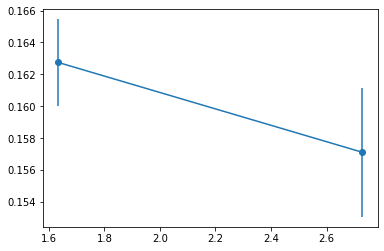

In [208]:
plt.errorbar(
    [max_min_loss, random_min_loss], 
    [max_delta_s_ave, random_delta_s_ave], 
    yerr=[float(max_delta_s_error), float(random_delta_s_error)],
    marker='o'
)
plt.show()

In [9]:
start_entropy = []
final_entropy = []
final_entropy_error = []
losses = {}
accuracy = {}
train_metrics = {}

for i in range(30):
    random_ds = random_agent.build_dataset(target_size=30)
    ntk = production_model.compute_ntk(x_i=random_ds, normalize=False)
    start_entropy.append(
        znrnd.analysis.EntropyAnalysis(
            matrix=ntk["empirical"]
        ).compute_von_neumann_entropy()
    )
    random_ds = {
    "inputs": np.take(data_generator.ds_train["image"], random_agent.target_indices, axis=0),
    "targets": np.take(data_generator.ds_train["label"], random_agent.target_indices, axis=0)
}
    entropy = []
    losses[i] = []
    accuracy[i] = []
    train_metrics[i] = []
    for _ in range(5):
        random_model = znrnd.models.NTModel(
            nt_module=model,
            optimizer=optax.adam(learning_rate=0.001),
            loss_fn=znrnd.loss_functions.CrossEntropyLoss(classes=10, apply_softmax=False),
            input_shape=(1, 28, 28, 1),
            training_threshold=0.001
        )
        random_loss, random_acc, training_metrics = random_model.train_model(
            train_ds=random_ds, test_ds=test_ds, batch_size=10, epochs=500
        )

        final_random_ntk = random_model.compute_ntk(random_ds["inputs"], normalize=False)
        entropy.append(znrnd.analysis.EntropyAnalysis(
            final_random_ntk["empirical"]
        ).compute_von_neumann_entropy())

        losses[i].append(random_loss)
        accuracy[i].append(random_acc)
        train_metrics[i].append(training_metrics)
        
    final_entropy.append(np.mean(entropy))
    final_entropy.append(np.std(entropy) / np.sqrt(5))

Epoch: 500: 100%|██████████████| 500/500 [02:04<00:00,  4.02batch/s, accuracy=0.638, test_loss=1.96]


Epoch: 500: 100%|██████████████| 500/500 [02:14<00:00,  3.72batch/s, accuracy=0.567, test_loss=3.65]
